# Large asymmetry test

We generate **N** galaxies with a varying size, magnitude, Sersic index, intrinsic asymmetry, sky magnitude, etc, and look at the behaviour of CAS and squared asymmetry metrics for these objects.

We draw each value of the following parameters from a uniform distribution with a min and a max value:

| Parameter | Min. | Max. |
| --- | --- | --- |
| Mag. | 10 | 16 |
| Sky RMS [mag/arcsec$^2$] | 20 | 26 |
| # clumps | 5 | 30 |
| PSF FWHM [arcsec] | 0 | 2 |
| Sersic n | 1 | 3 |

The radius of the generated galaxy is calculated as $-1.9 \textrm{mag} + 35$ arcsec, with a Gaussian scatter with $\sigma = 1.5$.

#### Imports

In [1]:
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('/home/jovyan/work/liza/matplotlibrc')
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.minor.size'] = 0#1.5
plt.rcParams['ytick.minor.size'] = 0#1.5
plt.rcParams['xtick.major.size'] = 2#3
plt.rcParams['ytick.major.size'] = 2#3
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.weight'] = 'light'

Read in all the pickle files with outputs for each generated galaxy:

In [3]:
# foldnames = [['var_mag1'], ['var_psf4', 'var_psf5', 'var_psf6'], ['var_all2', 'var_all3']]
# foldnames = [['var_skymag7'], ['var_psf4', 'var_psf5', 'var_psf6'], ['var_all2', 'var_all3']]
foldnames = [['var_mag3', 'var_mag4', 'var_mag5'], ['var_psf_new1'], ['var_apfrac2']]
data = []

for folders in foldnames:
    
    rows = []
    for folder in folders:
    
        files = []
        filenames = ! ls tests/{folder}
        for fn in filenames:    
            with open(f'tests/{folder}/{fn}', 'rb') as f:
                files.append(pickle.load(f))

        for f in files:
            f.pop('clump_properties')
            rows.append(f)
    
    df = pd.DataFrame(rows)
    df['log_snr'] = np.log10(df.snr)
    data.append(df)
    
    
# data[1] = data[1][data[1].psf_fwhm <= 2]
data[0] = data[0].sample(n=1000, random_state=0)
# data[2] = data[2].dropna().sample(n=1000, random_state=0)

Instead, just read in the CSV with the data:

In [4]:
data[0].to_csv('tests/rms.csv', index=False)
data[1].to_csv('tests/pxscale.csv', index=False)
data[2].to_csv('tests/apsize.csv', index=False)

Look at the distribution of CAS and squared asymmetry as a function of SNR

In [8]:
cmap = plt.get_cmap('YlGnBu')
cmap = cmap.from_list('custom', cmap(np.linspace(0.2,1,256)))
cmap2 = plt.get_cmap('OrRd_r')
cmap2 = cmap2.from_list('custom2', cmap2(np.linspace(0,0.9,256)))
# RdPu_r
cmap.set_under('#00000015')
# cmap.
# colors = cmap()
# cmap()

params = ['snr','psf_fwhm','ap_frac']
dfs = [data[0], data[1],data[2]]
mins = [0.99, 0.3, 1.05]
maxs = [10.8, 2.1, 2.59]
cmaps = [cmap, 'RdPu_r', cmap2]
cbar_labels = [
    r'$\langle$ SNR $\rangle$ per pixel',
    'PSF FWHM [arcsec]',
     r'Aperture size [R$_p$]'
]

s = 20
sizearr2 = data[2].snr*s
# sizearr2[sizearr2 > 100] = 150
sizearr = data[1].psf_fwhm*s
# sizearr[sizearr > 100] = 100
sizes = [s, s, s]
# arrowfracs = [0.12, 0, 0]


## Fitting the relationships

We want to provide fits to the relationship between observed and baseline asymmetry, which we do here...

Try to fit a function to it

$$A_{obs} = A_{base} \exp \left[-\left(\frac{\rm{p}}{\tau}\right)^{-\alpha}\right] $$

* $A_{obs}$ = $A_{base}$ when $(SNR/\tau)^{-\alpha} = 0$ i.e. SNR is high
* $A_{obs} = 0$ when SNR$ = 0$ 


Alternatively, try to fit simply
$$A_{obs} = A_{base} - m \times \textrm{p}$$

And see which fit gives a better reduced $\chi^2$.


<!-- $$ \ln A_{obs} = \ln A_{base} - \left(\frac{\rm{SNR}}{\tau}\right)^{-\alpha}  $$ -->


For CAS A and SNR, make the initial guess (1, 1) since there is a strong SNR dependence. For other cases, make the initial guess 


In [41]:
from scipy.optimize import curve_fit

    
    
    
def exp_fit(x, tau, alpha):
    a_base = x[0]
    param = x[1]    
    log_a = np.log(a_base) - np.power(param/tau, -alpha)
    a = np.power(np.e, log_a)
    return a

def lin_fit(x, m):
    a_base = x[0]
    param = x[1]    
    return a_base - m*param


def get_fit_param(a_baseline, a_obs, param_vals, init_guess_exp=[1,1], init_guess_lin=0.1):
    xdata = np.array([a_baseline, param_vals])
    ydata = a_obs
    try:
        exp_opt, _, exp_dict, _, _ = curve_fit(exp_fit, xdata, ydata, p0=init_guess_exp, full_output=True)
        chi2_exp = np.sum(exp_dict['fvec'])/(len(a_baseline)-2)
    except:
        chi2_exp = np.inf
    lin_opt, _, lin_dict, _, _ = curve_fit(lin_fit, xdata, ydata, p0=init_guess_lin, full_output=True)

    
    chi2_lin = np.sum(lin_dict['fvec'])/(len(a_baseline)-1)
    
    if chi2_exp < chi2_lin:
        return exp_opt
    else:
        return lin_opt

def get_fit(a_baseline, param, res):
    xdata = np.array([a_baseline, [param for a in a_baseline]])
    if len(res) == 1:
        return lin_fit(xdata, *res)
    else:
        return exp_fit(xdata, *res)
        

init_guess_exp = [
    [1,1], [1,0],[1,0]
]
init_guess_lin = [
    0.1, 0.1, 0.1
]

fit_vals = [
    [0.1, 0.5, 1, 3, 5, 10, 15],
    [0.3, 1, 1.5, 1],
    [1, 1.5, 2, 2.5]
]

## CAS Asymmetry

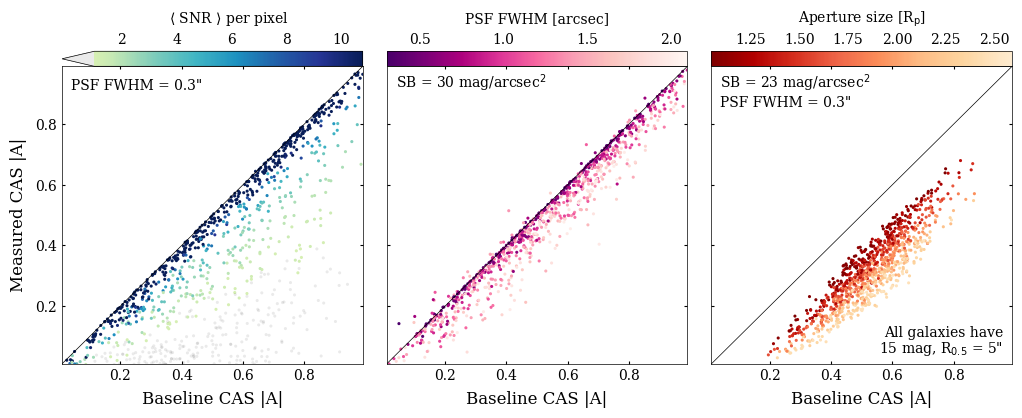

In [9]:
# data = data[data.snr > 10]

fig, axs = plt.subplots(1, 3, figsize=(9.5, 3.5), sharey=True)

for i, ax in enumerate(axs):
    
    df = dfs[i]
    col = params[i]
    im = ax.scatter(df.a_cas_real, df.a_cas, s=sizes[i], c=df[col], vmin=mins[i], vmax=maxs[i], cmap=cmaps[i]);
    if i == 0:
        c = fig.colorbar(im, ax=ax, extend='min', extendfrac=0.12, pad=0.0, 
                         orientation='horizontal', location='top')
    else:
        c = fig.colorbar(im, ax=ax,pad=0.0, orientation='horizontal', location='top')
    c.set_label(cbar_labels[i], labelpad=7)
    c.ax.tick_params(which='minor', size=0)
    c.ax.tick_params(which='major', size=0)
    
for ax in axs:
    ax.plot([0,1], [0,1], 'k', lw=0.5)
    ax.set_ylim(0.01,0.99); 
    ax.set_xlim(0.01,0.99)
    ax.set_xlabel('Baseline CAS |A|', size=12)

axs[0].set_ylabel('Measured CAS |A|', size=12)

# On the size plot, show relative sizes
axs[0].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.96), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate('SB = 30 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate('SB = 23 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.90), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'All galaxies have', xy=(0.97, 0.08), xycoords='axes fraction', ha='right', va='bottom')
axs[2].annotate(r'15 mag, R$_{0.5}$ = 5"', xy=(0.97, 0.02), xycoords='axes fraction', ha='right', va='bottom')

# colors = plt.get_cmap(cmaps[1])([0.1,0.5,0.8])
# axs[1].scatter([0.73, 0.83, 0.925], 3*[0.11], transform=axs[1].transAxes, s=np.array([0.3,1.5,3])*s, c=colors)
# reslabels = ['0.3"', '1.5"', '3"']
# for i, (l, c) in enumerate(zip(reslabels, colors)):
#     axs[1].annotate(l, xy=(0.73+0.1*i, 0.03), xycoords='axes fraction', ha='center', va='bottom',
#                    color=c)


# Add a colorbar
plt.subplots_adjust(wspace=0.08)
# cax = fig.add_axes([0.97, 0, 0.02, 1])
# c = fig.colorbar(im, cax=cax)
# c.set_label(r'$\langle$ SNR $\rangle$ per pixel')

# plt.savefig('figures/cas_tests.pdf', bbox_inches='tight', pad_inches=0)

New version of this plot, this time with errors and fits:

In [173]:
Xs = dftrain[['a_cas_real','snr']].values
ys = dftrain['a_cas'].values

opt = curve_fit(snr_fit, Xs.T, ys, p0=[1,1])[0]

[0.76258349 0.89753419]
[0.03595078]


/tmp/ipykernel_20884/3974468830.py:9: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a_base) - np.power(param/tau, -alpha)
/tmp/ipykernel_20884/3974468830.py:9: RuntimeWarning: invalid value encountered in power
  log_a = np.log(a_base) - np.power(param/tau, -alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.12031399]


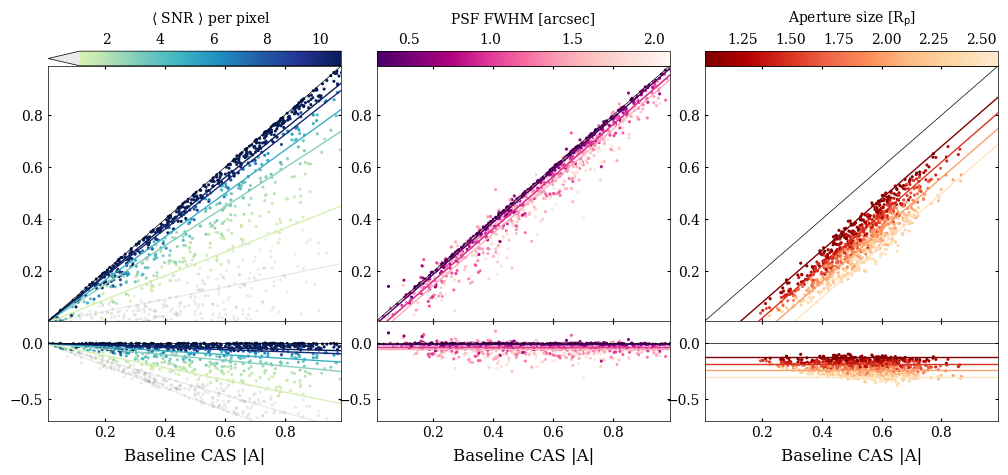

In [50]:
fig = plt.figure(figsize=(9.5, 4))
as_arr = np.linspace(0,1,11)
gs = fig.add_gridspec(2, 3,  width_ratios=(1, 1, 1), height_ratios=(3, 1),
                      left=0, right=1, bottom=0, top=1, wspace=0.12, hspace=0.0)

axs = []
for i in range(3):
    ax1 = fig.add_subplot(gs[0, i])
    ax2 = fig.add_subplot(gs[1, i], sharex=ax1)
    axs.append([ax1, ax2])
    
    # Measured vs baseline
    df = dfs[i]
    col = params[i]
    im = ax1.scatter(df.a_cas_real, df.a_cas, s=sizes[i], c=df[col], vmin=mins[i], vmax=maxs[i], cmap=cmaps[i]);
                
    # Error
    ax2.scatter(df.a_cas_real, df.a_cas-df.a_cas_real, s=sizes[i], c=df[col], vmin=mins[i], vmax=maxs[i], cmap=cmaps[i]);
    
    # Fits
    opt = get_fit_param(df.a_cas_real, df.a_cas, df[col].values)
    print(opt)
    for val in fit_vals[i]:
        ypred = get_fit(as_arr, val, opt)
        cmap = plt.get_cmap(cmaps[i])
        ax1.plot(as_arr, ypred, c=cmap((val-mins[i])/(maxs[i]-mins[i])), lw=1)
        ax2.plot(as_arr, ypred-as_arr, c=cmap((val-mins[i])/(maxs[i]-mins[i])), lw=1)
    

    # Colorbar
    if i == 0:
        c = fig.colorbar(im, ax=ax1, extend='min', extendfrac=0.12, pad=0.0, 
                         orientation='horizontal', location='top')
    else:
        c = fig.colorbar(im, ax=ax1,pad=0.0, orientation='horizontal', location='top')
    c.set_label(cbar_labels[i], labelpad=7)
    c.ax.tick_params(which='minor', size=0)
    c.ax.tick_params(which='major', size=0)
    
axs = np.array(axs)
# Ticks etc
for i in range(3):
    axs[i][0].plot([0,1], [0,1], 'k', lw=0.5)
    axs[i][0].set_ylim(0.01,0.99); 
    axs[i][0].set_xlim(0.01,0.99)
    axs[i][1].plot([0,1],[0,0], 'k', lw=0.5)
    axs[i][1].set_ylim(-0.69, 0.2);
    axs[i][1].set_xlabel('Baseline CAS |A|', size=12)
    
axs[0][0].legend()

#### Corrected asymmetry (not needed)

In [7]:

# fig, axs = plt.subplots(1, 3, figsize=(9.5, 3.5), sharey=True)

# for i, ax in enumerate(axs):
    
#     df = dfs[i]
#     col = params[i]
#     im = ax.scatter(df.a_cas_real, df.a_cas_corr, s=sizes[i], c=df[col], vmin=mins[i], vmax=maxs[i], cmap=cmaps[i]);
#     if i == 0:
#         c = fig.colorbar(im, ax=ax, extend='min', extendfrac=0.12, pad=0.0, 
#                          orientation='horizontal', location='top')
#     else:
#         c = fig.colorbar(im, ax=ax,pad=0.0, orientation='horizontal', location='top')
#     c.set_label(cbar_labels[i], labelpad=7)
#     c.ax.tick_params(which='minor', size=0)
#     c.ax.tick_params(which='major', size=0)
    
# for ax in axs:
#     ax.plot([0,1], [0,1], 'k', lw=0.5)
#     ax.set_ylim(0.01,0.99); 
#     ax.set_xlim(0.01,0.99)
#     ax.set_xlabel(r'Baseline |A|$_{corr}$', size=12)

# axs[0].set_ylabel(r'Measured |A|$_{corr}$', size=12)

# # On the size plot, show relative sizes
# axs[0].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.96), xycoords='axes fraction', ha='left', va='top')
# axs[1].annotate('SB = 30 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
# axs[2].annotate('SB = 23 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
# axs[2].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.90), xycoords='axes fraction', ha='left', va='top')
# axs[2].annotate(r'All galaxies have', xy=(0.97, 0.08), xycoords='axes fraction', ha='right', va='bottom')
# axs[2].annotate(r'15 mag, R$_{0.5}$ = 5"', xy=(0.97, 0.02), xycoords='axes fraction', ha='right', va='bottom')

# colors = plt.get_cmap(cmaps[1])([0.1,0.5,0.8])
# # axs[1].scatter([0.73, 0.83, 0.925], 3*[0.11], transform=axs[1].transAxes, s=np.array([0.3,1.5,3])*s, c=colors)
# # reslabels = ['0.3"', '1.5"', '3"']
# # for i, (l, c) in enumerate(zip(reslabels, colors)):
# #     axs[1].annotate(l, xy=(0.73+0.1*i, 0.03), xycoords='axes fraction', ha='center', va='bottom',
# #                    color=c)

# # Add a colorbar
# plt.subplots_adjust(wspace=0.08)
# # cax = fig.add_axes([0.97, 0, 0.02, 1])
# # c = fig.colorbar(im, cax=cax)
# # c.set_label(r'$\langle$ SNR $\rangle$ per pixel')

# # plt.savefig('figures/cas_corr_tests.pdf', bbox_inches='tight')

### Squared asymmetry

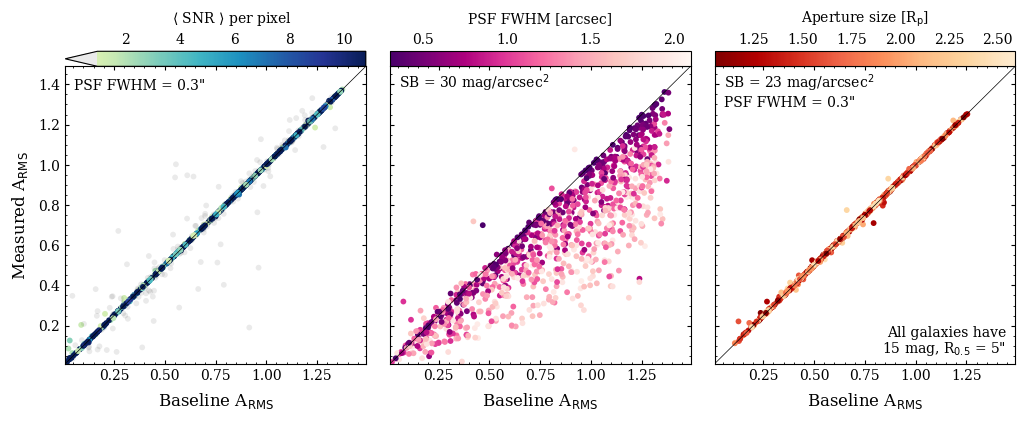

In [9]:

fig, axs = plt.subplots(1, 3, figsize=(9.5, 3.5), sharey=True)

for i, ax in enumerate(axs):
    
    df = dfs[i]
    col = params[i]
    im = ax.scatter(df.a_sq_real, df.a_sq, s=sizes[i], c=df[col], vmin=mins[i], vmax=maxs[i], cmap=cmaps[i]);
    if i == 0:
        c = fig.colorbar(im, ax=ax, extend='min', extendfrac=0.12, pad=0.0, 
                         orientation='horizontal', location='top')
    else:
        c = fig.colorbar(im, ax=ax,pad=0.0, orientation='horizontal', location='top')
    c.set_label(cbar_labels[i], labelpad=7)
    c.ax.tick_params(which='minor', size=0)
    c.ax.tick_params(which='major', size=0)
    
for ax in axs:
    ax.plot([0,3], [0,3], 'k', lw=0.5)
    ax.set_ylim(0.01,1.49); 
    ax.set_xlim(0.01,1.49)
    ax.set_xlabel(r'Baseline A$_{RMS}$', size=12)

axs[0].set_ylabel(r'Measured A$_{RMS}$', size=12)

# On the size plot, show relative sizes
axs[0].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.96), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate('SB = 30 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate('SB = 23 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.90), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'All galaxies have', xy=(0.97, 0.08), xycoords='axes fraction', ha='right', va='bottom')
axs[2].annotate(r'15 mag, R$_{0.5}$ = 5"', xy=(0.97, 0.02), xycoords='axes fraction', ha='right', va='bottom')

# colors = plt.get_cmap(cmaps[1])([0.1,0.5,0.8])
# axs[1].scatter([0.73, 0.83, 0.925], 3*[0.11], transform=axs[1].transAxes, s=np.array([0.3,1.5,3])*s, c=colors)
# reslabels = ['0.3"', '1.5"', '3"']
# for i, (l, c) in enumerate(zip(reslabels, colors)):
#     axs[1].annotate(l, xy=(0.73+0.1*i, 0.03), xycoords='axes fraction', ha='center', va='bottom',
#                    color=c)

# Add a colorbar
plt.subplots_adjust(wspace=0.08)
# cax = fig.add_axes([0.97, 0, 0.02, 1])
# c = fig.colorbar(im, cax=cax)
# c.set_label(r'$\langle$ SNR $\rangle$ per pixel')
# 
# plt.savefig('figures/rmsa_tests.pdf', bbox_inches='tight', pad_inches=0)

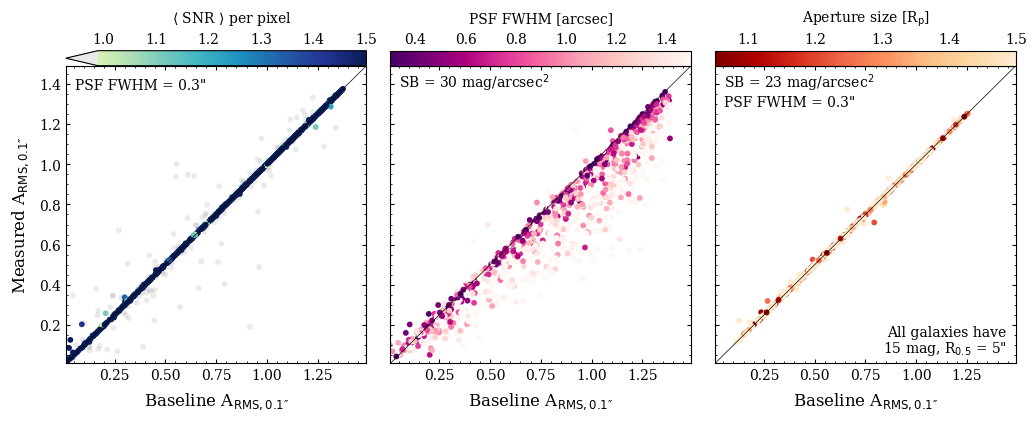

In [20]:
# data[2]['snr_eff'] = data[2].snr * (0.1/ data[2].pxscale)
# params = ['snr','psf_fwhm','snr_eff']
# # params = ['snr','psf_fwhm','snr']
# cbar_labels = [
#     r'$\langle$ SNR $\rangle$ per pixel',
#     'PSF FWHM [arcsec]',
#      r'Effective $\langle$ SNR $\rangle$ per pixel'
# ]


fig, axs = plt.subplots(1, 3, figsize=(9.5, 3.5), sharey=True)

for i, ax in enumerate(axs):
    
    df = dfs[i]
    col = params[i]
    im = ax.scatter(df.a_sq_real, df.a_fourier, s=sizes[i], c=df[col], vmin=mins[i], vmax=maxs[i], cmap=cmaps[i]);
    if i == 0:
        c = fig.colorbar(im, ax=ax, extend='min', extendfrac=0.12, pad=0.0, 
                         orientation='horizontal', location='top')
    else:
        c = fig.colorbar(im, ax=ax,pad=0.0, orientation='horizontal', location='top')
    c.set_label(cbar_labels[i], labelpad=7)
    c.ax.tick_params(which='minor', size=0)
    c.ax.tick_params(which='major', size=0)
    
    
for ax in axs:
    ax.plot([0,3], [0,3], 'k', lw=0.5)
    ax.set_ylim(0.01,1.49); 
    ax.set_xlim(0.01,1.49)
    ax.set_xlabel('Baseline A$_{RMS, 0.1\u2033}$', size=12)

axs[0].set_ylabel("Measured A$_{RMS, 0.1\u2033}$", size=12)

# On the size plot, show relative sizes
axs[0].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.96), xycoords='axes fraction', ha='left', va='top')
axs[1].annotate('SB = 30 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate('SB = 23 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate('PSF FWHM = 0.3"', xy=(0.03, 0.90), xycoords='axes fraction', ha='left', va='top')
axs[2].annotate(r'All galaxies have', xy=(0.97, 0.08), xycoords='axes fraction', ha='right', va='bottom')
axs[2].annotate(r'15 mag, R$_{0.5}$ = 5"', xy=(0.97, 0.02), xycoords='axes fraction', ha='right', va='bottom')

# colors = plt.get_cmap(cmaps[1])([0.1,0.5,0.8])
# axs[1].scatter([0.73, 0.83, 0.925], 3*[0.11], transform=axs[1].transAxes, s=np.array([0.3,1.5,3])*s, c=colors)
# reslabels = ['0.3"', '1.5"', '3"']
# for i, (l, c) in enumerate(zip(reslabels, colors)):
#     axs[1].annotate(l, xy=(0.73+0.1*i, 0.03), xycoords='axes fraction', ha='center', va='bottom',
#                    color=c)

# Add a colorbar
plt.subplots_adjust(wspace=0.08)
# cax = fig.add_axes([0.97, 0, 0.02, 1])
# c = fig.colorbar(im, cax=cax)
# c.set_label(r'$\langle$ SNR $\rangle$ per pixel')

plt.savefig('figures/rmsa_corr_tests.pdf', bbox_inches='tight', pad_inches=0)

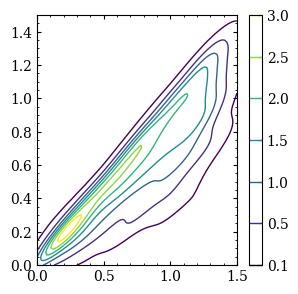

In [192]:
from scipy.stats import gaussian_kde
arr = df[['a_sq_real','a_sq']].values.T
kernel = gaussian_kde(arr, bw_method=0.3)

x = np.linspace(0,1.5,101)
y = np.linspace(0,1.5,101)
dx = np.diff(x)[0]
X, Y = np.meshgrid(x, y)

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
# Z *= 1000
# Z = Z*len(arr.T)/np.sum(Z)

plt.contour(X,Y,Z, levels=[0.1,0.5,1,1.5,2,2.5,3], linewidths=1)
# plt.contourf(Z)
plt.colorbar()

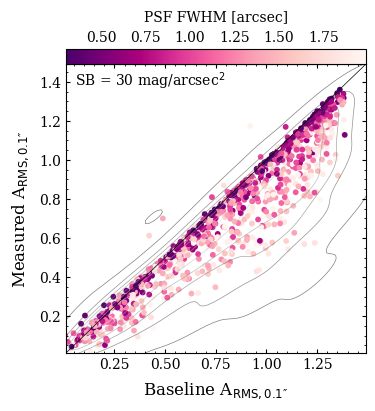

In [194]:
# data[2]['snr_eff'] = data[2].snr * (0.1/ data[2].pxscale)
# params = ['snr','psf_fwhm','snr_eff']
# # params = ['snr','psf_fwhm','snr']
# cbar_labels = [
#     r'$\langle$ SNR $\rangle$ per pixel',
#     'PSF FWHM [arcsec]',
#      r'Effective $\langle$ SNR $\rangle$ per pixel'
# ]


cmap = plt.get_cmap('RdPu_r')
fig, ax = plt.subplots(1, 1, figsize=(3, 3.4), sharey=True)

axs=[ax]

i=1
df = dfs[i]
col = params[i]

ax.contour(X,Y,Z, levels=[0.05,0.5,1,1.5,2,2.5,3], linewidths=0.5, cmap='gray', alpha=0.5)

im = ax.scatter(df.a_sq_real, df.a_fourier, s=sizes[i], c=df[col], vmin=mins[i], vmax=1.99, cmap=cmaps[i]);
c = fig.colorbar(im, ax=ax,pad=0.0, orientation='horizontal', location='top')
c.set_label(cbar_labels[i], labelpad=7)
c.ax.tick_params(which='minor', size=0)
c.ax.tick_params(which='major', size=0)
    
    
for ax in axs:
    ax.plot([0,3], [0,3], 'k', lw=0.5)
    ax.set_ylim(0.01,1.49); 
    ax.set_xlim(0.01,1.49)
    ax.set_xlabel('Baseline A$_{RMS, 0.1\u2033}$', size=12)

axs[0].set_ylabel("Measured A$_{RMS, 0.1\u2033}$", size=12)

# On the size plot, show relative sizes

ax.annotate('SB = 30 mag/arcsec$^2$', xy=(0.03, 0.98), xycoords='axes fraction', ha='left', va='top')


# colors = plt.get_cmap(cmaps[1])([0.1,0.5,0.8])
# axs[1].scatter([0.73, 0.83, 0.925], 3*[0.11], transform=axs[1].transAxes, s=np.array([0.3,1.5,3])*s, c=colors)
# reslabels = ['0.3"', '1.5"', '3"']
# for i, (l, c) in enumerate(zip(reslabels, colors)):
#     axs[1].annotate(l, xy=(0.73+0.1*i, 0.03), xycoords='axes fraction', ha='center', va='bottom',
#                    color=c)

# Add a colorbar
# plt.subplots_adjust(wspace=0.08)
# cax = fig.add_axes([0.97, 0, 0.02, 1])
# c = fig.colorbar(im, cax=cax)
# c.set_label(r'$\langle$ SNR $\rangle$ per pixel')

plt.savefig('figures/rmsa_corr_res_only.pdf', bbox_inches='tight', pad_inches=0)

# ax.set_aspect('equal')